<a href="https://colab.research.google.com/github/sneha1012/MultiModal-Genesis/blob/main/Conditional_GANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import drive
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras import backend as K
import time
from IPython.display import clear_output


Mounted at /content/drive


In [2]:
# Load the image dataset
data_location = "/content/drive/MyDrive/cond_data.npy"
data = np.load(data_location)



# Load the labels
labels_location = "/content/drive/MyDrive/ChestXray/cond_labels (1).npy"
labels = np.load(labels_location)



# Constants
NUM_EPOCHS = 100 # 10
LATENT_DIM = 100
INPUT_SHAPE = (128, 128, 1)
LEARNING_RATE = 0.0002
MOMENTUM = 0.5
BATCH_SIZE = 100 # 32
NUM_CLASSES = 7

# Mapping of classes
classes_list = ["No Finding", "Atelectasis", "Effusion", "Infiltration", "Mass", "Nodule", "Pneumothorax"]
classes = {"No Finding": 0, "Atelectasis": 1, "Effusion": 2, "Infiltration": 3, "Mass": 4, "Nodule": 5, "Pneumothorax": 6}
num_to_class = {v: k for k, v in classes.items()}

# Normalize data to [-1, 1]
data = (data - 127.5) / 127.5
print(data.shape)

(30242, 128, 128)


In [3]:
condition_to_name = {
    0: 'No Finding',
    1: 'Atelectasis',
    2: 'Effusion',
    3: 'Infiltration',
    4: 'Mass',
    5: 'Nodule',
    6: 'Pneumothorax',

}



**Discriminator Defintion**




In [4]:
def define_discriminator(in_shape=(128, 128, 1), n_classes=7, lr=0.0002, momentum=0.5):
  # label input
  in_label = layers.Input(shape=(1,))
  # embedding for categorical input
  li = layers.Embedding(n_classes, 50)(in_label)

  # Scale up
  n_nodes = in_shape[0] * in_shape[1]
  li = layers.Dense(n_nodes)(li)
  li = layers.Reshape((in_shape[0], in_shape[1], 1))(li)

  # Input Image
  in_image = layers.Input(shape=in_shape)

  #Add in label
  x = layers.Concatenate()([in_image, li])

  # 128, 128, 2
  x = layers.Conv2D(128, (5,5), strides=(2,2), padding='same')(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  # 64, 64, 128

  x = layers.Conv2D(128, (5,5), strides=(2,2), padding='same')(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  # 32, 32, 128

  x = layers.Conv2D(128, (5,5), strides=(2,2), padding='same')(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  # 16, 16, 128

  x = layers.Conv2D(128, (5,5), strides=(2,2), padding='same')(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  # 8, 8, 128

  x = layers.Flatten()(x)
  x = layers.Dropout(0.4)(x)
  out = layers.Dense(1, activation="sigmoid")(x)

  # Define model
  model = Model([in_image, in_label], out)

  # Compile model
  opt = Adam(learning_rate=lr, beta_1=momentum)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model


**Generator definiton**

In [5]:

def define_generator(latent_dim, n_classes=7):
  # label input
  in_label = layers.Input(shape=(1,))
  # embedding for categorical input
  li = layers.Embedding(n_classes, 50)(in_label)

  # Scale
  n_nodes = 8*8*64
  li = layers.Dense(n_nodes)(li)
  li = layers.Reshape((8,8,64))(li)

  # Latent Space Input
  in_lat = layers.Input(shape=(latent_dim, ))
  n_nodes = 64*8*8
  x = layers.Dense(n_nodes)(in_lat)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Reshape((8, 8, 64))(x)

  # Merge image and label
  x = layers.Concatenate()([x, li])
  # 8, 8, 128

  x = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  # 16, 16, 128

  x = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  # 32, 32, 128

  x = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  # 64, 64, 128

  x = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  # 128, 128, 128

  out = layers.Conv2D(1, (16,16), activation='tanh', padding='same')(x)

  # define model
  model = Model([in_lat, in_label], out)

  return model


**GAN(Generative adversial networks) Definition**

Both models sequentially for generator training

In [6]:
def define_gan(generator, discriminator, lr=0.0002, momentum=0.5):
  discriminator.trainable = False

  generator_lat, generator_label = generator.input
  generator_output = generator.output

  gan_output = discriminator([generator_output, generator_label])

  model = Model([generator_lat, generator_label], gan_output)

  opt = Adam(learning_rate=lr, beta_1=momentum)
  model.compile(loss='binary_crossentropy', optimizer=opt)

  return model

**Training Functions**

In [7]:

def load_real_samples(X, labels):
  X = np.expand_dims(X, axis=-1)
  X = X.astype('float32')
  X = (X - 127.5) / 127.5
  return [X, labels]


In [8]:
def generate_real_samples(dataset, n_samples):
  i = np.random.randint(0, dataset[0].shape[0], n_samples)
  X = dataset[0][i]
  labels = dataset[1][i]
  y = np.ones((n_samples, 1))

  return [X, labels], y

In [9]:

def generate_latent_points(latent_dim, n_samples, n_classes=7):
  x_input = np.random.randn(latent_dim*n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  labels = np.random.randint(0, n_classes, n_samples)
  return [x_input, labels]

In [10]:
def generate_fake_samples(generator, latent_dim, n_samples, n_classes=7):
  x_input, labels_input = generate_latent_points(latent_dim, n_samples, n_classes)
  X = generator.predict([x_input, labels_input])
  y = np.zeros((n_samples, 1))

  return [X, labels_input], y


In [11]:
condition_to_name = {
    0: 'No Finding',
    1: 'Atelectasis',
    2: 'Effusion',
    3: 'Infiltration',
    4: 'Mass',
    5: 'Nodule',
    6: 'Pneumothorax',

}


In [12]:
def train(gan, discriminator, generator, dataset, latent_dim, n_classes, n_epochs=10, batch_size=32, starting_epoch=0, model_name="", condition_to_name={}):


  batch_per_epoch = 32 #dataset[0].shape[0] // batch_size
  half_batch = batch_size // 2

  for epoch in range(starting_epoch, n_epochs+starting_epoch):
    start = time.time()
    for batch in range(batch_per_epoch):
      batch_start = time.time()
      # Real
      [X, labels], y = generate_real_samples(dataset, half_batch)
      d_loss1, _ = discriminator.train_on_batch([X,  labels], y)

      # Fake
      [X, labels], y = generate_fake_samples(generator, latent_dim, half_batch, n_classes)
      d_loss2, _ = discriminator.train_on_batch([X, labels], y)

      # GAN
      [X, labels] = generate_latent_points(latent_dim, batch_size, n_classes)
      y = np.ones((batch_size, 1))
      g_loss = gan.train_on_batch([X, labels], y)

      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (epoch+1, batch+1, batch_per_epoch, d_loss1, d_loss2, g_loss))
      print('Time for batch {}/{} of epoch {} is {} sec'.format(batch+1, batch_per_epoch, epoch + 1, time.time()-batch_start))

    clear_output(wait=True)

    ### PERFORMANCE CHECK
    X, y = generate_real_samples(dataset, 100) # real
    _, acc_real = discriminator.evaluate(X, y, verbose=0)
    X, y = generate_fake_samples(generator, latent_dim, 100, n_classes) # fake
    _, acc_fake = discriminator.evaluate(X, y, verbose=0)
    print("Disc Accuracy Real: %.5f, fake: %.5f" % (acc_real, acc_fake))
    print('Epoch %d: d1=%.3f, d2=%.3f g=%.3f' % (epoch+1, d_loss1, d_loss2, g_loss))

    genloss.append(g_loss)
    discloss.append((d_loss1+d_loss2)/2)
    accReal.append(acc_real)
    accFake.append(acc_fake)

    generate_and_save_images(generator, discriminator, epoch + 1, np.random.randn(1, latent_dim), genloss, discloss, accReal, accFake, n_classes, model_name, condition_to_name)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    # generator.save("/content/drive/MyDrive/ChestXray/models/" + model_name + "/intermediate" + str(epoch) + "_generator.h5")
    # discriminator.save("/content/drive/MyDrive/ChestXray/models/" + model_name + "/intermediate" + str(epoch) + "_discriminator.h5")
    # # np.savetxt("/content/drive/MyDrive/ChestXray/models/" + model_name + "/intermediate" + str(epoch) + "_genloss.csv", gen_loss, delimiter=",")
    # # np.savetxt("/content/drive/MyDrive/ChestXray/models/" + model_name + "/intermediate" + str(epoch) + "_discloss.csv", disc_loss, delimiter=",")
    # np.savetxt("/content/drive/MyDrive/ChestXray/models/" + model_name + "/intermediate" + str(epoch) + "_genloss.csv",  delimiter=",")
    # np.savetxt("/content/drive/MyDrive/ChestXray/models/" + model_name + "/intermediate" + str(epoch) + "_discloss.csv", delimiter=",")
    # np.savetxt("/content/drive/MyDrive/ChestXray/models/" + model_name + "/intermediate" + str(epoch) + "_accreal.csv", acc_real, delimiter=",")
    # np.savetxt("/content/drive/MyDrive/ChestXray/models/" + model_name + "/intermediate" + str(epoch) + "_accfake.csv", acc_fake, delimiter=",")


In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import save_model

def generate_and_save_images(model, discriminator, epoch, test_input, gen_loss, disc_loss, acc_real, acc_fake, n_conditions, model_name, condition_to_name):
    base_path = "/content/drive/MyDrive/ChestXray/models"
    model_path = os.path.join(base_path, model_name)

    if epoch % 10 == 0:
        # Ensure the directory exists
        if not os.path.exists(model_path):
            os.makedirs(model_path)

        # Try saving models and data
        try:
            save_model(model, os.path.join(model_path, f"intermediate{epoch}_generator.h5"))
            save_model(discriminator, os.path.join(model_path, f"intermediate{epoch}_discriminator.h5"))
            np.savetxt(os.path.join(model_path, f"intermediate{epoch}_genloss.csv"), gen_loss, delimiter=",")
            np.savetxt(os.path.join(model_path, f"intermediate{epoch}_discloss.csv"), disc_loss, delimiter=",")
            np.savetxt(os.path.join(model_path, f"intermediate{epoch}_accreal.csv"), acc_real, delimiter=",")
            np.savetxt(os.path.join(model_path, f"intermediate{epoch}_accfake.csv"), acc_fake, delimiter=",")
        except Exception as e:
            print(f"Error saving models/data at epoch {epoch}. Error: {str(e)}")

    fig, axs = plt.subplots(1, n_conditions)
    for condition in range(n_conditions):
        predictions = model.predict([test_input, np.array([condition])])

        axs[condition].imshow(predictions[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
        axs[condition].axis('off')
        axs[condition].set_title(condition_to_name[condition], fontsize=10)
    plt.show()



TRAIN THE MODEL

LOAD THE DATSET

In [14]:

dataset = load_real_samples(np.load(data_location), np.load(labels_location))

Train

4/4 [==============================] - 0s 62ms/step


Disc Accuracy Real: 0.80000, fake: 0.89000
Epoch 100: d1=0.354, d2=0.284 g=2.354
1/1 [==============================] - 0s 19ms/step


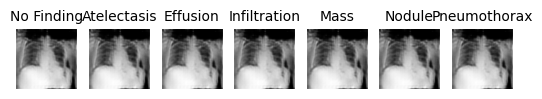

Time for epoch 100 is 37.81453084945679 sec


In [15]:

discriminator = define_discriminator(in_shape=INPUT_SHAPE,n_classes=NUM_CLASSES, lr=LEARNING_RATE, momentum=MOMENTUM)
generator = define_generator(LATENT_DIM, n_classes=NUM_CLASSES)
gan = define_gan(generator=generator, discriminator=discriminator, lr=LEARNING_RATE, momentum=MOMENTUM)

genloss = []
discloss = []
accReal = []
accFake = []

train(gan=gan, discriminator=discriminator, generator=generator, dataset=dataset, latent_dim=LATENT_DIM, n_classes=NUM_CLASSES, batch_size=BATCH_SIZE, n_epochs=NUM_EPOCHS, model_name="your_model_name", condition_to_name=condition_to_name)


Visualise Results and Training metrics

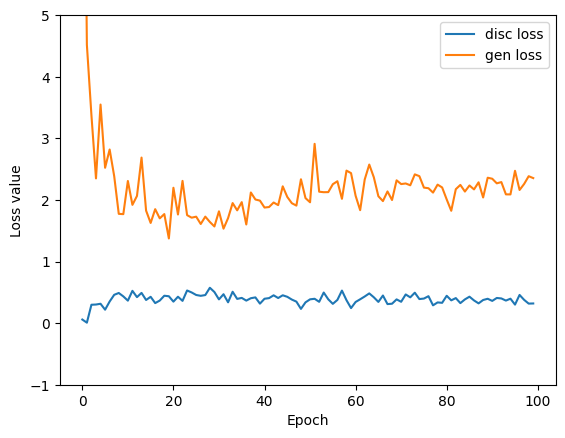

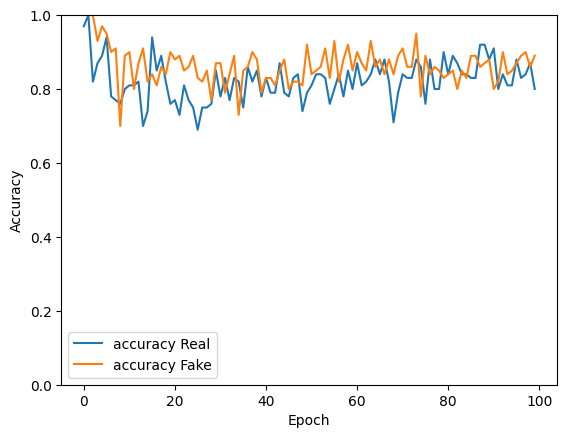

In [16]:
plt.plot(range(len(discloss)), discloss, label='disc loss')
plt.plot(range(len(genloss)), genloss, label='gen loss')
plt.xlabel('Epoch')
plt.ylim(-1,5)
plt.ylabel('Loss value')
plt.legend()
plt.show()


plt.plot(range(len(accReal)), accReal, label='accuracy Real')
plt.plot(range(len(accFake)), accFake, label='accuracy Fake')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# def show_plot(label, n_samples, latent_dim=100, latent_space=np.random.randn(1,100)):
#   predictions = generator.predict([latent_space, np.array([label])])
#   plt.imshow(predictions[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
#   plt.axis('off')
#   plt.title(num_to_class[label])
#   plt.show()

# latent = np.random.randn(1,100)
# for i in range(NUM_CLASSES):
#   show_plot(i, 1, 100, latent)


# show_plot(generator.predict(generate_latent_points(100, 1)), 1)
